In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame
from energy_consumption.models.lasso import functions

### 1. Include all desired features 
* make sure they are still reasonable
* Assume Lasso can handle this 

In [2]:
# important to standardize X for lasso regression
# use derived opt for quantReg
energydata = extract_all_features.get_energy_and_standardized_features(
    lasso=True)[-54027:]

y = energydata[['energy_consumption']]
X = energydata.drop(columns=['energy_consumption'])
X.insert(loc=0, column='constant', value=1)
X = X.drop(columns=['year_2016', 'year_2024'])

did you update weather and index?
2016-12-26 00:00:00
2023-11-23 12:00:00


In [4]:
correlation_matrix = X.corr()

# Find pairs of variables with absolute correlation value greater than 0.1
high_corr_pairs = [(i, j) for i in range(correlation_matrix.shape[0])
                   for j in range(i+1, correlation_matrix.shape[1])
                   if abs(correlation_matrix.iloc[i, j]) > 0.7]

# Create a copy of the original predictor matrix
X_pol = X.copy()

# Add interaction terms for selected pairs
for pair in high_corr_pairs:
    col1, col2 = X.columns[pair[0]], X.columns[pair[1]]
    name = f"{col1}_{col2}"
    X_pol[name] = X_pol[col1] * \
        X_pol[col2]

# add polynomials 
X_pol['tavg_2'] = X_pol['tavg']**2
X_pol['wspd_2'] = X_pol['wspd']**2
X_pol['sun_hours_2'] = X_pol['sun_hours']**2

In [ ]:
X_pol

In [7]:
# Time-based split for time series data
tscv = TimeSeriesSplit(n_splits=20, test_size=100)  # Adjust the number of splits as needed

# Create LassoCV model with time series cross-validation
# let alphas = None to automatically compute best alpha
lasso_cv = LassoCV(cv=tscv,max_iter=1000)

# Fit the model on the scaled data
lasso_cv.fit(X_pol, y)

# Find the best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")

c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha: 0.054736124202112


In [8]:
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_pol, y)
print(list(zip(lasso_best.coef_, X_pol)))

[(0.0, 'constant'), (-0.891746306574632, 'hour_1'), (-1.0687697477881355, 'hour_2'), (-1.0541987697841566, 'hour_3'), (-0.8710970840242753, 'hour_4'), (-0.40801273585393416, 'hour_5'), (0.5005753052859472, 'hour_6'), (1.3795573666523906, 'hour_7'), (1.968106586100085, 'hour_8'), (2.2641733680760225, 'hour_9'), (2.510953292175824, 'hour_10'), (2.7251044322309523, 'hour_11'), (2.641270785002751, 'hour_12'), (2.3999188638362488, 'hour_13'), (2.13410628841603, 'hour_14'), (1.9759874004057276, 'hour_15'), (1.9026254563161362, 'hour_16'), (2.1119569243881524, 'hour_17'), (2.223309088026213, 'hour_18'), (2.1005612462667544, 'hour_19'), (1.6152332052657785, 'hour_20'), (1.1035236338859926, 'hour_21'), (0.6151839487530285, 'hour_22'), (-0.0, 'hour_23'), (0.2840252695728002, 'day_1'), (0.32283511653157804, 'day_2'), (0.29597311500527573, 'day_3'), (0.007169946812920021, 'day_4'), (-2.7176591077312735, 'day_5'), (-3.914309659704672, 'day_6'), (0.49846586687725325, 'month_2'), (-0.0, 'month_3'), (

How to estimate forecast variance? 
--> estimate residuals for each forecast horizon (p=100). 
If we estimate more than 40, we can assume they are normal distributed. 

In [33]:
# Perform time series split
tscv = TimeSeriesSplit(n_splits=200, test_size=100)
indexes = list(range(100))
residuals = pd.DataFrame()
for i in indexes:
    residuals[f'{i}'] = np.nan

for train_index, test_index in tscv.split(X_pol):
        
        # fit Lasso Regression with best alpha
        lasso = Lasso(alpha=0.0547)
        
        # make sure we have enough data to train (models stay comparable)
        if test_index[0] >= 27014:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Fit the model on the scaled data
            lasso.fit(X_train, y_train)

            # estimate forecast means
            mean_est = lasso.predict(X_test)[indexes]

            # residuals based on horizon
            y_obs = np.array(y_test).flatten()
            residuals_est = mean_est-y_obs

            #safe 
            residuals.loc[len(residuals)] = residuals_est

In [34]:
# export residuals to avoid additional computational effort
residuals.to_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals.csv', index=False)

# check if residuals vary over time 
--> iterate over rows, check if there is trend in mean/variance of residuals
--> works

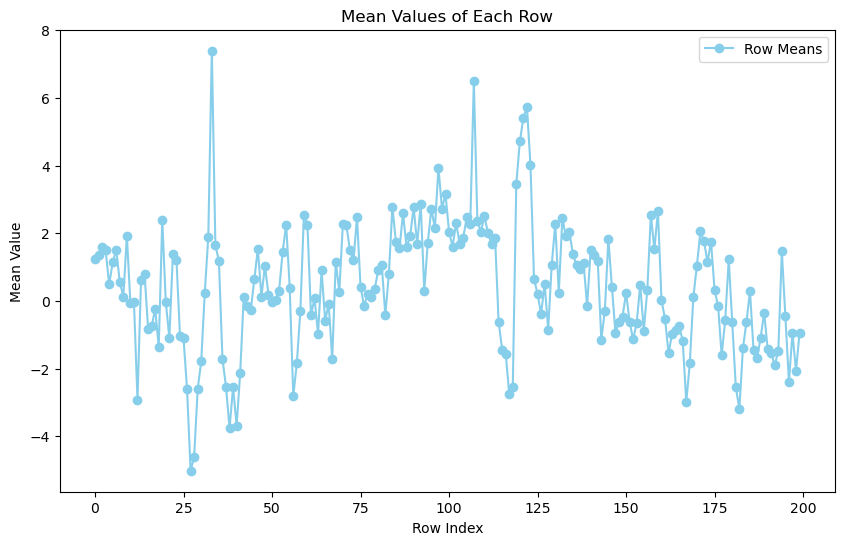

In [36]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df, replace the ellipsis (...) with your actual data
# For example, df = pd.DataFrame(...) with your data

# Calculate the mean of each row
row_means = residuals.mean(axis=1)

# Plot the mean values
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, row_means, marker='o', linestyle='-',
         color='skyblue', label='Row Means')
plt.title('Mean Values of Each Row')
plt.xlabel('Row Index')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# further variances to consider: temp, wspd and prodInd

estimated beta-coefficients: 
tavg: -1.2216133138213232
Wspd: 0.8548540440664917
index: 1.5901698880678983

add to variance: 
beta_hat^2 * var^2

In [19]:
# Note: the more comparisons we have, the better. However, we started very lately with including weather data. Therefore, this  is just a proxy.
from sklearn.preprocessing import StandardScaler

# proxy for tavg and wspd: 
weather_obs = pd.read_csv(
    'C:/Users/Maria/Documents/Studium/Pyhton Projekte/PTSFC/energy_consumption/feature_selection/data/weather_01172024.csv')
weather_est = pd.read_csv(
    'C:/Users/Maria/Documents/Studium/Pyhton Projekte/PTSFC/energy_consumption/feature_selection/data/weather_010824.csv')

# Extract numeric columns for standardization (comparably the same length as training data for lasso regression)
cols = ['wspd', 'tavg']

# Standardize the columns
scaler = StandardScaler()

weather_est[cols] = scaler.fit_transform(
    weather_est[cols])
weather_obs[cols] = scaler.transform(
    weather_obs[cols])

# Rename and select relevant columns
weather_est_date = weather_est[['date', 'wspd', 'tavg']].rename(
    columns={'wspd': 'wspd_est', 'tavg': 'tavg_est'})
weather_obs_date = weather_obs[-16:][['date', 'wspd', 'tavg']
                                     ].rename(columns={'wspd': 'wspd_obs', 'tavg': 'tavg_obs'})

# Merge DataFrames based on the 'date' column
merged_df = pd.merge(weather_est_date, weather_obs_date,
                     on='date', how='inner')
merged_df['tavg_residual'] = merged_df['tavg_obs'] - merged_df['tavg_est']
merged_df['wspd_residual'] = merged_df['wspd_obs'] - merged_df['wspd_est']

var_to_add_wsp = merged_df['wspd_residual'].var() # (0.6418)
var_to_add_temp = merged_df['tavg_residual'].var()  # (0.0370)
var_to_add_wsp

# residuals do not really make sense since they are higher for later periods --> just add the same portion to each horizon

0.6417705151559819

Variance proxy for production index
--> Production index estimated with OLS --> estimate variance of OLS estimation

In [15]:
from energy_consumption.feature_selection.collect import production_index

# get unscaled energydata since OLS residuals are unscaled as well
energydata_unsc = extract_all_features.get_energy_and_features(
    lasso=True)[-54027:]
index_data_unsc = energydata_unsc['index']

var_est = index_data_unsc.var()
mean_est = index_data_unsc.mean()

residuals = production_index.merge_production_indexes(energydata_unsc)[2]

mean_res = residuals.mean()
var_est = residuals.var()

# standardize residuals
res_standardized = (residuals-mean_res)/(var_est)
var_to_add = res_standardized.var()
var_to_add # (0.0378)

did you update weather and index?
2016-12-26 00:00:00
2023-11-23 12:00:00


0.037842703248219776

In [23]:
overall_variance_to_add = var_to_add * (1.5901698880678983)**2 + \
    var_to_add_temp*(-1.2216133138213232)**2 + \
    var_to_add_wsp*(0.8548540440664917)**2

overall_variance_to_add #(0.6198)

0.6198233246882933

Use alpha = 0.0547 for Lasso Regression

In [5]:
def get_interaction_and_pol_terms(X): 

    # interaction term for sun_hours and tavg
    X['sun_hours_tavg'] = X['sun_hours'] * X['tavg']
            
    # Add polynomials
    X['tavg_2'] = X['tavg']**2
    X['wspd_2'] = X['wspd']**2
    X['sun_hours_2'] = X['sun_hours']**2

    return X

In [18]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from math import sqrt

def get_quantiles(mean_est, quantiles=[0.025, 0.25, 0.5, 0.75, 0.975]):

    mean_est = np.array(mean_est)
    quantile_df = pd.DataFrame()

    # lasso variance
    residuals = pd.read_csv(
        'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals.csv')
    residual_std = np.sqrt(residuals.var(axis=0))

    # add variance due to forecasts of regressors
    std_to_add = sqrt(0.619823324688293)

    for q in quantiles:
        if q < 0.5:
            quantile_df[f'q{q}'] = mean_est + \
                residual_std*norm.ppf(q, loc=0) - std_to_add
        elif q == 0.5:
            quantile_df[f'q{q}'] = mean_est
        else:
            quantile_df[f'q{q}'] = mean_est + \
                residual_std*norm.ppf(q, loc=0) - std_to_add

    return quantile_df

In [17]:
from math import sqrt
residuals = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals.csv')
np.sqrt(residuals.var(axis=0))

0     3.215884
1     3.363386
2     3.553124
3     3.543380
4     3.221469
        ...   
95    3.423234
96    2.996263
97    3.077307
98    3.241473
99    3.628056
Length: 100, dtype: float64

In [21]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame

def get_Lasso_forecasts(energydata=pd.DataFrame(), indexes=[47, 51, 55, 71, 75, 79],
                        quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], periods=100):

    # get standardized features
    energydata = extract_all_features.get_energy_and_standardized_features(
        lasso=True)[-54027:]

    # split df
    y = energydata[['energy_consumption']]
    X = energydata.drop(columns=['energy_consumption'])
    X.insert(loc=0, column='constant', value=1)
    X = get_interaction_and_pol_terms(X)

    # fit Lasso Regression with best alpha 
    lasso = Lasso(alpha=0.0547)

    # Fit the model on the scaled data
    lasso.fit(X, y)

    # create dataframe to store forecast quantiles
    X_fc = get_forecast_timestamps.forecast_timestamps(
        energydata.index[-1])
    X_fc = extract_all_features.get_energy_and_standardized_features(
        X_fc, lasso=True)
    X_fc = get_interaction_and_pol_terms(X_fc)
    X_fc.insert(loc=0, column='constant', value=1)

    # estimate forecast means
    mean_est = lasso.predict(X_fc).flatten()

    # estimate quantile forecasts
    quantile_forecasts = get_quantiles(
        mean_est, quantiles).iloc[indexes]
    

    # return quantile forecasts in terms of absolute evaluation
    abs_eval = len(quantiles) != 6
    if abs_eval == True:
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        quantile_forecasts.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return quantile_forecasts

    # else: create submission frame
    else:
        forecast_frame = create_submission_frame.get_frame(
            quantile_forecasts, indexes)
        forecast_frame = forecast_frame.drop(columns={'index'})
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        forecast_frame.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return forecast_frame


forecast_frame = get_Lasso_forecasts()
forecast_frame

did you update weather and index?
2016-12-26 00:00:00
2023-11-23 12:00:00
did you update weather and index?
2023-11-22 13:00:00
2023-11-27 16:00:00


,date_time,q0.025,q0.25,q0.5,q0.75,q0.975
47,2023-11-24 12:00:00,58.329632,62.785605,65.910947,67.461712,71.917685
51,2023-11-24 16:00:00,53.234229,57.917417,61.161979,62.831964,67.515152
55,2023-11-24 20:00:00,52.565125,57.367740,60.674966,62.407616,67.210231
71,2023-11-25 12:00:00,53.813827,58.454742,61.677124,63.324929,67.965844
75,2023-11-25 16:00:00,49.070691,53.707781,56.928156,58.573954,63.211045
79,2023-11-25 20:00:00,48.262595,53.110273,56.441144,58.197437,63.045115
